# MARCH MADNESS Predictor
Authors: Connor Finn, Riley Greene <br>
Data: March 14, 2020

In [77]:
# we will be using the following packages
import pandas as pd
import numpy as np
import copy

# Read in our Data

In [78]:
season_stats = pd.read_csv("clean_data/season_stats.csv")
teams = pd.read_csv("clean_data/teams.csv")
ncaa_games = pd.read_csv("clean_data/ncaa_games.csv")
schools = pd.read_csv("clean_data/schools.csv")
tournament_stats = pd.read_csv("tournament_data/prelim_data.csv")


# Normalize the Data

We will do this with a z-score normalization

In [79]:
season_stats.iloc[: , 1:] = (season_stats.iloc[: , 1:] - season_stats.iloc[: , 1:].mean())/season_stats.iloc[: , 1:].std()
tournament_stats.iloc[: , 1:] = (tournament_stats.iloc[: , 1:] - tournament_stats.iloc[: , 1:].mean())/tournament_stats.iloc[: , 1:].std()

In [80]:
tournament_stats.head()

,Team,FG,FGA,FG%,2P,2PA,2P%,3P,3PA,3P%,...,STL,BLK,TOV,PF,PTS/G,W-L%,SRS,SOS,opp_PPG,Seed
0,kansas,0.432825,-0.588745,1.339182,1.005115,0.353514,1.259721,-0.843544,-1.044838,-0.063699,...,0.867007,0.969694,0.223318,-1.440534,0.194986,1.776313,1.844086,1.071014,-1.280238,-1.614218
1,san-diego-state,0.447313,0.030428,0.676067,-0.403062,-0.817547,0.580593,1.368833,0.975948,1.270507,...,0.461612,-0.968631,-1.073720,0.199202,0.238017,2.125925,0.811453,-0.290021,-1.602501,-1.398989
2,maryland,-1.117377,-0.428958,-1.354723,-1.254157,-1.248498,-0.421928,0.094312,0.975948,-1.286721,...,-1.540026,0.595631,-0.924062,-1.256064,-0.407453,0.487741,0.723569,0.871278,-0.259740,-1.183760
3,kentucky,-0.378496,-0.938277,0.385954,0.788473,1.149836,-0.324910,-1.853542,-2.341599,-0.100760,...,-1.033282,1.241740,-0.001169,0.896090,0.151954,0.807387,0.403421,0.333934,0.169943,-0.968531
4,butler,-0.653765,-1.297797,0.344509,-0.356638,-0.714494,0.483575,-0.530925,-0.580165,-0.174883,...,-0.957271,-1.172665,-0.949005,-0.108248,-1.117469,-0.151551,0.368896,0.630887,-0.904265,-0.753302


# Build Feature Vector

In [81]:
# make a new dataframe:
data_matrix = ncaa_games.copy()

In [82]:
def build_feat_vec(r):
    """ 
    This function builds the feature vec by subtracting team_1's stats from team_2's stats
    """
    s1 = season_stats[season_stats["team_id"] == r["team_1_id"] ]
    s2 = season_stats[season_stats["team_id"] == r["team_2_id"] ]
    # reset the indices: this is important for subtraction
    s2 = s2.reset_index(drop=True)
    s1 = s1.reset_index(drop=True)   
    # subtract the two stat sets
    s3 = s1.sub(s2) 
    s3 = s3.iloc[0]
    # append the difference to the game information
    r = r.append(s3)
    # somehow return the information.
    return r
data_matrix = data_matrix.apply(build_feat_vec , axis = 1)

we can get rid of the team_id columns because of the game_id. 
we will use the scores to create a binary: 0 if team 1 loses, 1 if team 1 wins


In [83]:
# Build the result column
data_matrix["result"] = np.where(data_matrix['team_1_score'] > data_matrix['team_2_score'], 1, 0)

In [84]:
# remove unwanted columns
data_matrix = data_matrix.drop(["team_1_id" , "team_2_id" , "team_id" , "team_1_score" , "team_2_score"] , axis = 1)

# Feature Engineering

* Do we want to create any new variable?
* For now, lets simply reduce any overlap (i.e. FT = FTA * FT%)
    + We do not need all three

In [85]:
data_matrix = data_matrix.drop(["game_id" , "FT" , "2P" , "3P" , "FG" , "TRB"] , axis = 1)
tournament_stats = tournament_stats.drop([ "FT" , "2P" , "3P" , "FG" , "TRB"] , axis = 1)

In [86]:
tournament_stats.rename(columns = {'opp_PPG': 'PTS.1'})

,Team,FGA,FG%,2PA,2P%,3PA,3P%,FTA,FT%,ORB,...,STL,BLK,TOV,PF,PTS/G,W-L%,SRS,SOS,PTS.1,Seed
0,kansas,-0.588745,1.339182,0.353514,1.259721,-1.044838,-0.063699,0.123305,-1.333236,0.095964,...,0.867007,0.969694,0.223318,-1.440534,0.194986,1.776313,1.844086,1.071014,-1.280238,-1.614218
1,san-diego-state,0.030428,0.676067,-0.817547,0.580593,0.975948,1.270507,-0.928176,1.392200,-0.558180,...,0.461612,-0.968631,-1.073720,0.199202,0.238017,2.125925,0.811453,-0.290021,-1.602501,-1.398989
2,maryland,-0.428958,-1.354723,-1.248498,-0.421928,0.975948,-1.286721,0.697826,0.763253,0.368524,...,-1.540026,0.595631,-0.924062,-1.256064,-0.407453,0.487741,0.723569,0.871278,-0.259740,-1.183760
3,kentucky,-0.938277,0.385954,1.149836,-0.324910,-2.341599,-0.100760,1.066387,2.073559,-0.503668,...,-1.033282,1.241740,-0.001169,0.896090,0.151954,0.807387,0.403421,0.333934,0.169943,-0.968531
4,butler,-1.297797,0.344509,-0.714494,0.483575,-0.580165,-0.174883,-1.177497,0.265337,-0.867082,...,-0.957271,-1.172665,-0.949005,-0.108248,-1.117469,-0.151551,0.368896,0.630887,-0.904265,-0.753302
5,auburn,0.509788,-0.774498,-0.920601,0.612933,1.613522,-1.472028,2.312989,-1.149794,1.694983,...,-0.095806,1.173728,0.298147,1.469998,0.926517,0.807387,0.287289,0.321561,1.324717,-0.538073
6,west-virginia,0.160255,-1.230389,1.393417,-1.133395,-1.433866,-2.213253,1.489147,-1.988389,2.585346,...,0.892344,-0.186500,1.495413,0.978077,-0.730187,-0.481185,0.831854,0.896024,-0.823700,-0.322844
7,saint-marys-ca,1.079027,1.131958,0.803202,0.386557,0.241116,1.863487,-0.245255,0.946696,-1.230495,...,0.537624,-1.648745,-1.273265,0.773110,0.345595,0.397840,-0.147421,-0.058468,0.384785,-0.107615
8,oklahoma,-0.089412,-1.313279,-0.358491,-0.907019,0.316761,-1.027292,-0.429536,1.261170,-1.248666,...,-0.323841,0.629637,-1.048777,-2.239906,-0.751703,-1.120477,0.042471,0.896024,0.519061,0.107615
9,texas-tech,-0.928291,0.012951,-0.461545,-0.195552,-0.472102,0.343975,-0.115175,0.946696,-0.885252,...,0.917681,0.255574,0.896780,0.424666,-0.385937,-1.440123,0.568203,0.501854,-0.528292,0.322844


In [87]:
data_matrix.columns

Index(['FGA', 'FG%', '2PA', '2P%', '3PA', '3P%', 'FTA', 'FT%', 'ORB', 'DRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS/G', 'W-L%', 'SRS', 'SOS',
       'opp_PPG', 'Seed', 'result'],
      dtype='object')

## Split the dataset into training and testing data

In [88]:
from sklearn.model_selection import train_test_split
# split the data
Y = data_matrix.iloc[: , -1]
X = data_matrix.iloc[: , :-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Linear Regression 
in this section, we will assume there exists a linear relationship y = wx. We want to optimize. <dir> First, lets create a correlation matrix and see what linear relationships exist

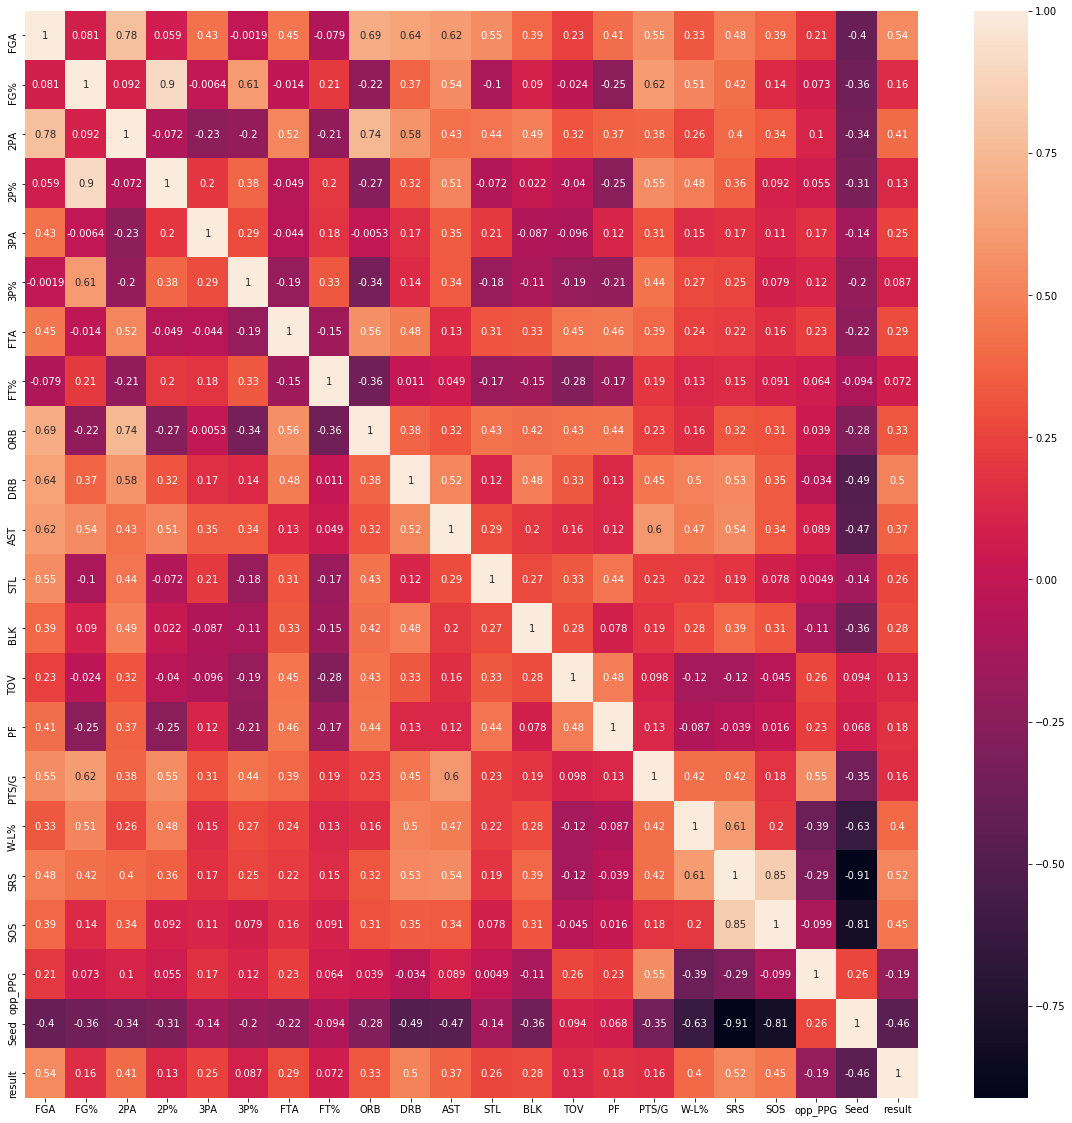

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
corr=data_matrix.corr()
ax=sns.heatmap(corr,annot=True)

Some notable results: <dir>
    * defensive rebounds are more correlated with wins than offensive rebounds
    * almost no correlation between FT% and Wins in NCAA tournament!
    * low correlation between 3P% and 3PA 
        + Perhaps this is something that can be accounted for.
        + Feature engineering could be useful - see what percentage of shots were 3P 

# Decision Tree Classifier

#### Hyperparameters
* https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
* Rafael Gomes Mantovani, Tomáš Horváth, Ricardo Cerri, Sylvio Barbon Junior, Joaquin Vanschoren, André Carlos Ponce de Leon Ferreira de Carvalho, “An empirical study on hyperparameter tuning of decision trees” arXiv:1812.02207 " 
* Maybe we should use a random forest instead of a decision tree classifier.

In [89]:
# put the hyperparameters we will tune here
depth = 13     # 13 is the default
mss = 20       # best range for CART = 1 - 40
msl = 15       # best range for CART = 1-20


In [90]:
from sklearn import tree
# Build Classifier
model = tree.DecisionTreeClassifier(max_depth = depth , min_samples_split = mss , min_samples_leaf = msl)

# fit the classifier
model.fit(x_train, y_train)

#make predictions
predicted_results = model.predict(x_test)

In [91]:
print(model.tree_.max_depth)


6


In [92]:
predicted_results


array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1])

In [93]:
y_test.values

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1])

In [94]:
model.score(x_train, y_train)

0.8549905838041432

In [95]:
model.score(x_test , y_test)

0.7518796992481203

# Nueral Net

This is adapted from the TF example https://www.tensorflow.org/tutorials/keras/classification

Right now this is a shallow nueral net (one hidden layer). <dir> 
  * this [post](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) seems to be very usefuel for information on shallow nueral nets.
  * Looking into a deep nueral net could be more useful

In [97]:
import tensorflow as tf
from tensorflow import keras
nueral_net_data = data_matrix.copy()

In [98]:
from sklearn.model_selection import train_test_split
# split the data
Y_nn = nueral_net_data.iloc[: , -1]
X_nn = nueral_net_data.iloc[: , :-1]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, Y_nn, test_size=0.2)

### Build the Nueral Net

In [99]:

input_shape = (21,)  # The shape of the data. This cannot be changed.
num_categories = 2 # The number of labelled categories in our classification scheme. This cannot be changed.
hidden_units_list = [16, 64, 256 , 11]

# These are our layers
num_hidden_units = 8
activation_list = ['sigmoid', 'relu', 'tanh'] # Different options of activation function
activation = activation_list[1]

nueral_net = keras.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(num_hidden_units, activation=activation),
    keras.layers.Dropout(.1) , 
    keras.layers.Dense(num_hidden_units, activation=activation),
    keras.layers.Dense(num_categories, activation='softmax')
])

print(f"The model is built using {num_hidden_units} hidden units and a {activation} activation function")



The model is built using 8 hidden units and a relu activation function


In [100]:
# adam helps get out of local optima
nueral_net.compile(optimizer='adam', # adam is an adaptive gradient optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

nueral_net.fit(x_train, y_train, epochs=30)

Train on 531 samples
Epoch 1/30
531/531 [==============================] - 0s 508us/sample - loss: 0.7169 - accuracy: 0.5085
Epoch 2/30
531/531 [==============================] - 0s 41us/sample - loss: 0.6847 - accuracy: 0.5687
Epoch 3/30
531/531 [==============================] - 0s 40us/sample - loss: 0.6542 - accuracy: 0.6516
Epoch 4/30
531/531 [==============================] - 0s 37us/sample - loss: 0.6357 - accuracy: 0.6648
Epoch 5/30
531/531 [==============================] - 0s 38us/sample - loss: 0.6159 - accuracy: 0.7137
Epoch 6/30
531/531 [==============================] - 0s 40us/sample - loss: 0.5896 - accuracy: 0.7232
Epoch 7/30
531/531 [==============================] - 0s 36us/sample - loss: 0.5877 - accuracy: 0.7232
Epoch 8/30
531/531 [==============================] - 0s 36us/sample - loss: 0.5702 - accuracy: 0.7514
Epoch 9/30
531/531 [==============================] - 0s 34us/sample - loss: 0.5633 - accuracy: 0.7439
Epoch 10/30
531/531 [==============================

In [101]:
test_loss, test_acc = nueral_net.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

133/133 - 0s - loss: 0.5148 - accuracy: 0.8120

Test accuracy: 0.8120301


# Run the tournament

In [102]:
# Recall, we stored the dictionary of teams in the tournament in  "ncaa_framework"
%store -r ncaa_teams

In [103]:


## build the tournament

class tournament():
    
   
    def __init__(self , teams , model ):
        self.origional = teams
        self.teams = copy.deepcopy(teams)               # this needs to be a list of dictionary's south , west, midwest , east, teams in seed order
        self.games = {}
        self.rounds = []
        self.round_32 = []
        self.round_16 = []
        self.round_8 = []
        self.final_four = [ 0 , 0 , 0 , 0]
        self.finals = None
        self.champion = None
        self.model = model
         
    # this method will play the entire tournament by alternating playing make_games and play_round
    def play_tournament(self):
        while self.champion == None:
            self.make_games()
            self.play_round()

    # this method resets the tournament, but uses the origional set of teams.
    def reset(self):
        self.teams = self.origional
        self.games = {}
        self.rounds = []
        self.round_32 = []
        self.round_16 = []
        self.round_8 = []
        self.final_four = [ 0 , 0 , 0 , 0]
        self.finals = None
        self.champion = None
        self.model = model
        
        
    # this method builds the next round of games using the results of the play_round() method
    def make_games(self):
        # this makes all the games for each region - if only one team left: it will return no games
        for region in self.teams:
            reg_teams = self.teams[region] # this get's the teams and puts them into a list
            games = []
            for i in range(len(reg_teams) // 2):
                games += [game(reg_teams[i] , reg_teams[(i + 1) * -1]  , model = self.model , team_data = tournament_stats)]
            self.games[region] = games

    # The following method will play a single round of the tournamnet
    # it is important to note that it considers the final four, and championship as one round
    # At the conclusion, it sets the self.teams to be just the winners. keeping track of each
    # round in self.rounds
    # the final four / finals round returns self.champion as the overall winner
    def play_round(self):
        
        games_played = []
        counter = 0        
        for region in self.games:
            l_games = list(self.games[region])
            l_teams = list(self.teams[region])
            if len(l_teams) != 1:
                winners = []
                
                for g in l_games:
                    g.play_model()
                    #game.print_results
                    winners += [g.winner]
                    games_played += [g]
                # update the teams in the tournament
                self.teams[region] = winners

            else:
                # make the final four
                self.final_four[counter] = self.teams[region][0]
                # play the final four  # this needs to be the correct pairing
                        # update the counter
            counter += 1
        # update the rounds
        if games_played != []:
            self.rounds += [games_played] 
        if self.final_four[0] != 0:
            game1 = game(self.final_four[0] , self.final_four[1], model = self.model , team_data = tournament_stats)
            game1.play_model()
            game2 = game(self.final_four[2] , self.final_four[3], model = self.model , team_data = tournament_stats)
            game2.play_model()
            
            # put winners in finals 
            self.finals = [game1.winner , game2.winner]
                
            self.rounds += [ [game1 , game2] ]
                
            # play the final
            final_game = game(self.finals[0] , self.finals[1], model = self.model , team_data = tournament_stats)
                
            final_game.play_model()
            self.champion = final_game.winner
            self.rounds += [[final_game]]


    def short_describe(self):
        final_four = self.rounds[-2]
        finals = self.rounds[-1]
        
        print("In the Final Four,  ")
        for game in final_four:
            game.print_results()
        print("In the finals,  ")
        finals[-1].print_results()
        
    def give_results(self):
        round_count = 1
        for r in self.rounds:
            print("In round " , round_count)
            round_count += 1
            for game in r:
                game.print_results()
            print("   ")
            
              
class game():
    
    def __init__(self, team1 , team2 , model = None , team_data = None):
        self.team_one = team1
        self.team_two = team2
        self.model = model
        self.team_data = team_data
        self.winner = None
        self.loser = None
        

    def print_results(self):
        print(self.winner , " will beat " , self.loser)
        
    # this method plays a game assuming each team has equal chance of winning. 
    def play_even(self):
        choice = np.random.uniform()
        if choice <= 0.5:
            self.winner = self.team_one
            self.loser  = self.team_two
        else:
            self.winner = self.team_two
            self.loser  = self.team_one
            
    def play_model(self):
        model = self.model
        # need to build the feature vector
        s1 = self.team_data[self.team_data["Team"] == self.team_one ]
        s2 = self.team_data[self.team_data["Team"] == self.team_two ]
        s1 = s1.drop(["Team" ] , axis = 1)
        s2 = s2.drop(["Team" ] , axis = 1)
        # need to reset their indices
        s2 = s2.reset_index(drop=True)
        s1 = s1.reset_index(drop=True)   
        # subtract the two stat sets
        feature_vector = s1.sub(s2) 
        # get prediction
        choice = model.predict(feature_vector)   # if you import decision tree
        #choice = model.predict_classes(feature_vector)  # if you import nueral net
        if choice == 1:
            self.winner = self.team_one
            self.loser  = self.team_two
        else:
            self.winner = self.team_two
            self.loser  = self.team_one
            

In [104]:
t = tournament(ncaa_teams , model)
t.play_tournament()
t.short_describe()
t.give_results()

In the Final Four,  
belmont  will beat  saint-marys-ca
rutgers  will beat  duke
In the finals,  
belmont  will beat  rutgers
In round  1
kansas  will beat  mississippi-state
san-diego-state  will beat  rhode-island
maryland  will beat  tennessee
richmond  will beat  kentucky
purdue  will beat  butler
arizona-state  will beat  auburn
west-virginia  will beat  texas-tech
saint-marys-ca  will beat  oklahoma
gonzaga  will beat  siena
wright-state  will beat  florida-state
belmont  will beat  louisville
villanova  will beat  vermont
penn-state  will beat  tulsa
iowa  will beat  texas
xavier  will beat  arizona
houston  will beat  louisiana-state
hofstra  will beat  baylor
seton-hall  will beat  radford
duke  will beat  yale
oregon  will beat  akron
liberty  will beat  brigham-young
colorado  will beat  northern-iowa
illinois  will beat  florida
providence  will beat  indiana
dayton  will beat  north-carolina-central
michigan-state  will beat  utah-state
creighton  will beat  wichita-state
